In [1]:
#%load_ext autoreload
#%autoreload 2
import os
import joblib
import sys

from braindecode.datautil.iterators import get_balanced_batches
from eeggan.examples.conv_cub.model import Generator,Discriminator
from eeggan.util import weight_filler
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
%matplotlib inline


In [2]:
#from mne.io import read_raw_cnt
#raw_fname = '/home/jcuomo/793/04.cnt'
#montage_fname = 'standard-10-5-cap385.elp'
#raw = read_raw_cnt(raw_fname, eog=('HEOG', 'VEOG'), emg=('EMG',), preload=True, verbose=True)

In [3]:
def normalize(signal):
    x = signal - signal.mean()
    x /= x.std()
    x /= x.max()
    return x

In [4]:
plt.switch_backend('agg')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.enabled=True
torch.backends.cudnn.benchmark=True



n_critic = 2
n_batch = 64
jobid = 0

n_z = 200*8
lr = 0.001
n_channels = 1
n_blocks = 4
input_length = 12*2**n_blocks
rampup = 200.
block_epochs = [2000]
for i in range(n_blocks-1):
    block_epochs = np.append(block_epochs,4000)

task_ind = 0
np.random.seed(task_ind)
torch.manual_seed(task_ind)
torch.cuda.manual_seed_all(task_ind)
random.seed(task_ind)
rng = np.random.RandomState(task_ind)

#data = os.path.join('/home/jcuomo/793/cba/cba1ff01.dat')
#EEG_data = joblib.load(data)
#train_set = EEG_data['train_set']
#test_set = EEG_data['test_set']
#train = np.concatenate((train_set.X,test_set.X))
#target = np.concatenate((train_set.y,test_set.y))


#train = np.random.rand(1000,1,input_length)
train = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')
print(train.shape)
#train = train[:,None,:]

train = train[:,:,:,None]
train = train-train.mean()
train = train/train.std()
train = train/np.abs(train).max()
#target_onehot = np.zeros((target.shape[0],2))
#target_onehot[:,target] = 1

train = train.astype(float)
train = np.swapaxes(train,1,3)
train.shape

(900, 8, 192)


(900, 1, 192, 8)

In [5]:
modelpath = './'
modelname = 'Progressive'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)


generator = Generator(n_channels, n_blocks,n_z)
discriminator = Discriminator(n_channels,n_blocks)

generator.train_init(alpha=lr,betas=(0.,0.99))
discriminator.train_init(alpha=lr,betas=(0.,0.99),eps_center=0.001,
                        one_sided_penalty=True,distance_weighting=True)
generator = generator.apply(weight_filler)
discriminator = discriminator.apply(weight_filler)

i_block_tmp = 0
i_epoch_tmp = 0
generator.model.cur_block = i_block_tmp
discriminator.model.cur_block = n_blocks-1-i_block_tmp
fade_alpha = 1.
generator.model.alpha = fade_alpha
discriminator.model.alpha = fade_alpha

generator = generator.cuda()
discriminator = discriminator.cuda()
generator.train()
discriminator.train()

losses_d = []
losses_g = []
i_epoch = 0
z_vars_im = rng.normal(0,1,size=(100,n_z)).astype(np.float32)

In [14]:
#checkpoint = torch.load('Progressive0.disc')
#discriminator.load_state_dict(checkpoint[0])
#
#checkpoint = torch.load('Progressive0.gen')
#generator.load_state_dict(checkpoint[0])
#
#i_block_tmp = 3
#i_epoch_tmp = 3400

<All keys matched successfully>

i_block: 3 / 4 , i_epoch: 3900 / 4000
Epoch: 3900   Loss_F: -0.340   Loss_R: -0.092   Penalty: 0.0487   Loss_G: -0.064


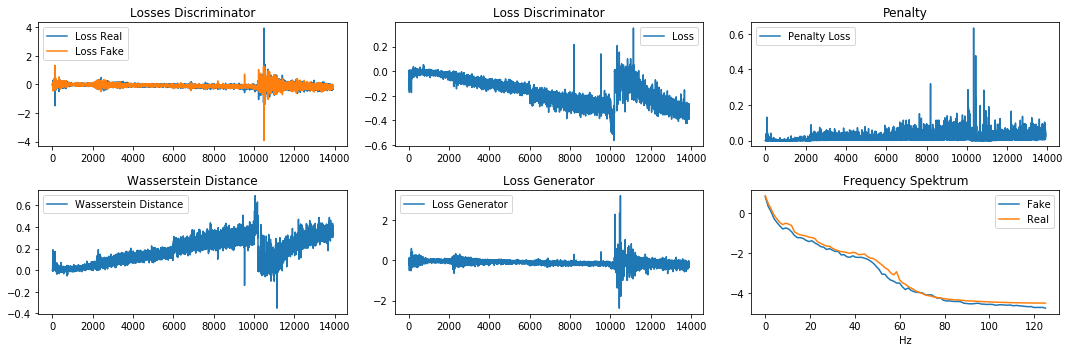

END


In [6]:
%matplotlib inline
for i_block in range(i_block_tmp,n_blocks):
    c = 0
    train_tmp = discriminator.model.downsample_to_block(Variable(torch.from_numpy(train).cuda(),volatile=True),discriminator.model.cur_block).data.cpu()
    for i_epoch in range(i_epoch_tmp,block_epochs[i_block]):
        #print(i_block,i_epoch)
        i_epoch_tmp = 0

        if fade_alpha<1:
            fade_alpha += 1./rampup
            generator.model.alpha = fade_alpha
            discriminator.model.alpha = fade_alpha

        batches = get_balanced_batches(train.shape[0], rng, True, batch_size=n_batch)
        iters = int(len(batches)/n_critic)

        for it in range(iters):
            for i_critic in range(n_critic):
                #print("########### i_block, i_epoch, it, i_critic",i_block, i_epoch, it, i_critic)
                train_batches = train_tmp[batches[it*n_critic+i_critic]]
                batch_real = Variable(train_batches,requires_grad=True).cuda()
                z_vars = rng.normal(0,1,size=(len(batches[it*n_critic+i_critic]),n_z)).astype(np.float32)
                z_vars = Variable(torch.from_numpy(z_vars),volatile=True).cuda()
                batch_fake = Variable(generator(z_vars).data,requires_grad=True).cuda()
                loss_d = discriminator.train_batch(batch_real,batch_fake)
                assert np.all([torch.isfinite(ld) for ld in loss_d])
            z_vars = rng.normal(0,1,size=(n_batch,n_z)).astype(np.float32)
            z_vars = Variable(torch.from_numpy(z_vars),requires_grad=True).cuda()
            loss_g = generator.train_batch(z_vars,discriminator)

        losses_d.append(loss_d)
        losses_g.append(loss_g)

        with torch.no_grad():
            if i_epoch%100 == 0:
                clear_output()
                print('i_block:',i_block, '/',n_blocks ,', i_epoch:',i_epoch,'/',block_epochs[i_block])
                generator.eval()
                discriminator.eval()

                print('Epoch: %d   Loss_F: %.3f   Loss_R: %.3f   Penalty: %.4f   Loss_G: %.3f'%(i_epoch,loss_d[0],loss_d[1],loss_d[2],loss_g))
                joblib.dump((i_epoch,losses_d,losses_g),os.path.join(modelpath,modelname+str(jobid)+'_.data'),compress=True)
                joblib.dump((i_epoch,losses_d,losses_g),os.path.join(modelpath,modelname+str(jobid)+'_%d.data'+str(i_epoch)),compress=True)
                #joblib.dump((n_epochs,n_z,n_critic,batch_size,lr),os.path.join(modelpath,modelname%jobid+'_%d.params'%i_epoch),compress=True)

                freqs_tmp = np.fft.rfftfreq(train_tmp.numpy().shape[2],d=1/(250./np.power(2,n_blocks-1-i_block)))

                train_fft = np.fft.rfft(train_tmp.numpy(),axis=2)
                train_amps = np.abs(train_fft).mean(axis=3).mean(axis=0).squeeze()


                z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
                
                batch_fake = generator(z_vars)
                fake_fft = np.fft.rfft(batch_fake.data.cpu().numpy(),axis=2)
                fake_amps = np.abs(fake_fft).mean(axis=3).mean(axis=0).squeeze()

                plt.close()
                plt.figure(figsize=(15,5))
                plt.subplot(2,3,6)
                plt.plot(freqs_tmp,np.log(fake_amps),label='Fake')
                plt.plot(freqs_tmp,np.log(train_amps),label='Real')
                plt.title('Frequency Spektrum')
                plt.xlabel('Hz')
                plt.legend()
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_fft_%d_%d.png'%(i_block,i_epoch)))

               # for i in range(10):
               #     plt.subplot(10,1,i+1)
               #     plt.plot(batch_fake[i].squeeze())
               #     plt.xticks((),())
               #     plt.yticks((),())
               # plt.subplots_adjust(hspace=0)
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_fakes_%d_%d.png'%(i_block,i_epoch)))
                #plt.close()

                discriminator.save_model(os.path.join(modelpath,modelname+str(jobid)+'.disc'))
                generator.save_model(os.path.join(modelpath,modelname+str(jobid)+'.gen'))

                plt.subplot(2,3,1)
                plt.plot(np.asarray(losses_d)[:,0],label='Loss Real')
                plt.plot(np.asarray(losses_d)[:,1],label='Loss Fake')
                plt.title('Losses Discriminator')
                plt.legend()
                plt.subplot(2,3,2)
                plt.plot(np.asarray(losses_d)[:,0]+np.asarray(losses_d)[:,1]+np.asarray(losses_d)[:,2],label='Loss')
                plt.title('Loss Discriminator')
                plt.legend()
                plt.subplot(2,3,3)
                plt.plot(np.asarray(losses_d)[:,2],label='Penalty Loss')
                plt.title('Penalty')
                plt.legend()
                plt.subplot(2,3,4)
                plt.plot(-np.asarray(losses_d)[:,0]-np.asarray(losses_d)[:,1],label='Wasserstein Distance')
                plt.title('Wasserstein Distance')
                plt.legend()
                plt.subplot(2,3,5)
                plt.plot(np.asarray(losses_g),label='Loss Generator')
                plt.title('Loss Generator')
                plt.legend()
                plt.tight_layout()
                plt.show()
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_losses.png'))
                #plt.close()

                generator.train()
                discriminator.train()


    fade_alpha = 0.
    generator.model.cur_block += 1
    discriminator.model.cur_block -= 1
print("END")
generator.model.cur_block -= 1
discriminator.model.cur_block += 1

In [7]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
box_pts = 100
dr = smooth(np.asarray(losses_d)[:,0], box_pts)
df = smooth(np.asarray(losses_d)[:,1], box_pts)
g =  smooth(np.asarray(losses_g), box_pts)

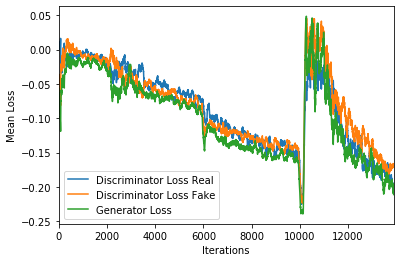

In [13]:
plt.plot(dr,label='Discriminator Loss Real')
plt.plot(df ,label='Discriminator Loss Fake')
plt.plot(g ,label='Generator Loss')
plt.xlim([0,13899])

plt.xlabel('Iterations')
plt.ylabel('Mean Loss')
plt.legend()

In [ ]:
torch.save(generator, 'non_gen4')
torch.save(discriminator, 'non_disc4')

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


Text(0.5, 0, 'Time samples')

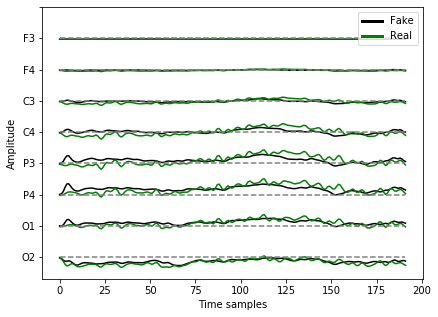

In [10]:
from scipy.signal import welch, hanning

def fft(x, fs=256, nblock = 1024, overlap = 128):
    if nblock > x.shape[-1]:
        nblock = x.shape[-1]
    win = hanning(nblock, True)
    f1, Pxxf1 = welch(x, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True, detrend=False)
    return f1, Pxxf1

fake = np.swapaxes(batch_fake[:60,0].cpu().detach().numpy(), 1,2).mean(0)
real = np.swapaxes(batch_real[:,0].cpu().detach().numpy(), 1,2).mean(0)

freq, fake_fft = fft(fake)
freq, real_fft = fft(real)


from matplotlib.lines import Line2D
electrodes = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']
electrodes = [ele for ele in reversed(electrodes)]

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in ['k','g']]
labels = ['Fake', 'Real']

plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
scale = 0.1
plt.plot(fake.T+ scale*np.arange(7,-1,-1), 'k');
plt.plot(real.T+ scale*np.arange(7,-1,-1), 'g');
plt.plot(np.zeros((192,8)) + scale*np.arange(7,-1,-1),'--',color='gray');
plt.yticks(np.arange(0, 0.9, step=scale), electrodes);
plt.legend(lines, labels, loc='upper right')


plt.ylabel('Amplitude')
plt.xlabel('Time samples')


torch.Size([64, 192, 8]) (64, 192, 8)
192 128
192 128


/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  """


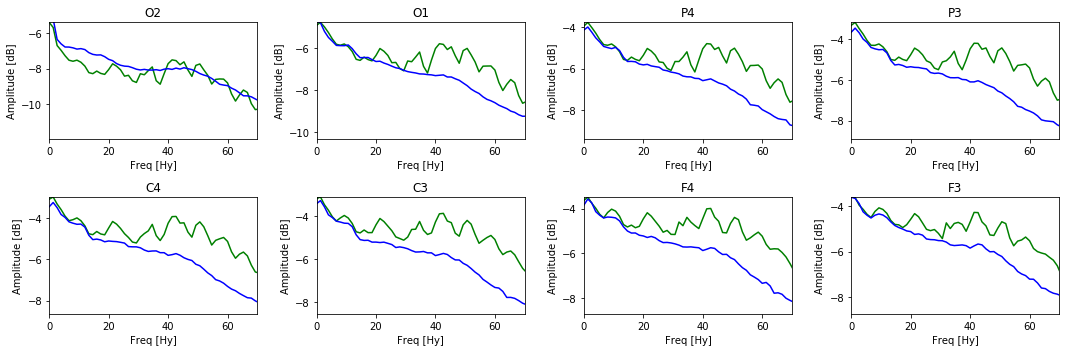

In [29]:
def fft(x, fs=256, nblock = 1024, overlap = 128):
    if nblock > x.shape[-1]:
        nblock = x.shape[-1]
    print(nblock, overlap)
    win = hanning(nblock, True)
    f1, Pxxf1 = welch(x, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True, detrend=False)
    return f1, Pxxf1

def normalize(signal):
    x = signal - signal.mean()
    x /= x.std()
    x /= x.max()
    return x

def denormalize(x,std,mean,maximum):
    return x*std*maximum+mean

realN = normalize(batch_real)
mean = batch_real.mean()
std = (batch_real-mean).std()
maximum = ((batch_real-mean)/std).max()
realD = denormalize(realN,std,mean,maximum).squeeze()


fakeN = normalize(batch_fake[:64])
mean = batch_fake.mean()
std = (batch_fake-mean).std()
maximum = ((batch_fake-mean)/std).max()
fakeD = denormalize(fakeN,std,mean,maximum).squeeze()
print(realD.shape, fakeD.shape)

realD = realD.cpu().detach().numpy()
fakeD = fakeD

realD = np.swapaxes(realD,1,2)
fakeD = np.swapaxes(fakeD,1,2)


freq, real_fft = fft(realD)
freq, fake_fft = fft(fakeD)

real_fft = real_fft.mean(axis=0)
fake_fft = fake_fft.mean(axis=0)

plt.figure(figsize=(15,5))

for i in range(8):
    plt.subplot(2,4,i+1)
    
    plt.title(electrodes[i])
    plt.plot(freq, np.log10(real_fft[i]), 'g', label='real');
    plt.plot(freq, np.log10(fake_fft[i]), 'b', label='fake');
    plt.xlabel('Freq [Hy]')
    plt.ylabel('Amplitude [dB]')
    plt.xlim(0,70);
    #plt.ylim(10-2,1);
    plt.tight_layout();
    plt.ylim(np.min(np.log10(real_fft[i,0:60])), np.max(np.log10(real_fft[i,0:60])))

In [12]:
batch_fake = generator(z_vars).detach().cpu().numpy()

for i in range(10):
    z_vars_im = rng.normal(0,1,size=(100,n_z)).astype(np.float32)
    z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
    batch_fake1 = generator(z_vars).detach().cpu().numpy()
    batch_fake = np.vstack((batch_fake,batch_fake1))
np.save('non_p300_fake4', batch_fake)
batch_fake.shape

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


(1064, 1, 192, 8)

In [7]:
state = {'epoch': 0 + i_epoch + 1,'state_dict': generator.model.state_dict()}
torch.save(state, 'generator_nont.model')

In [8]:
torch.save(generator, 'gen_nont')

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ProgressiveGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Progr

In [17]:
generator = torch.load('gen_nont')
generator.eval()
z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
batch_fake = generator(z_vars)
batch_fake.shape

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([100, 1, 192, 8])

In [18]:
z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
batch_fake = generator(z_vars).detach().cpu().numpy()

for i in range(5):
    z_vars_im = rng.normal(0,1,size=(100,n_z)).astype(np.float32)
    z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
    batch_fake1 = generator(z_vars).detach().cpu().numpy()
    batch_fake = np.vstack((batch_fake,batch_fake1))
batch_fake.shape

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.
/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


(600, 1, 192, 8)

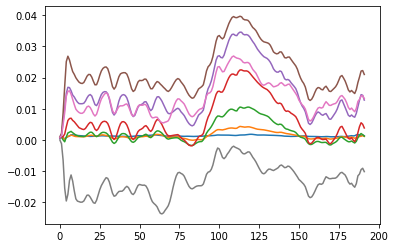

In [19]:
%matplotlib inline
ff = batch_fake[:].squeeze()
ffm = np.mean(ff,axis=0)
plt.plot(ffm)
plt.show()

3400

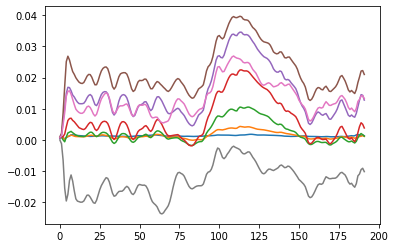

In [22]:
ff = batch_fake[:].squeeze()
ffm = np.mean(ff,axis=0)
plt.plot(ffm)
plt.show()

In [20]:
np.save('fake_non_target', batch_fake)

In [21]:
from scipy.signal import welch, hanning

def fft(x, fs=256, nblock = 1024, overlap = 128):
    if nblock > x.shape[-1]:
        nblock = x.shape[-1]
    win = hanning(nblock, True)
    f1, Pxxf1 = welch(x, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True, detrend=False)
    return f1, Pxxf1

In [ ]:
import bandpass as bp
from scipy import signal

eeg = np.load('non_p300_ch.npy')
filtered =  bp.bandpass(eeg, 0.01, 50, 256, corners=5, zerophase=True, axis=1)
feeg, Pxxeeg = fft(eeg)
ffiltered, Pxxfiltered = fft(filtered)

In [31]:
ff1 = np.swapaxes(ff, 1,2)
freq, ff_fft = fft(ff1)
ff_fft.shape

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


(600, 8, 97)

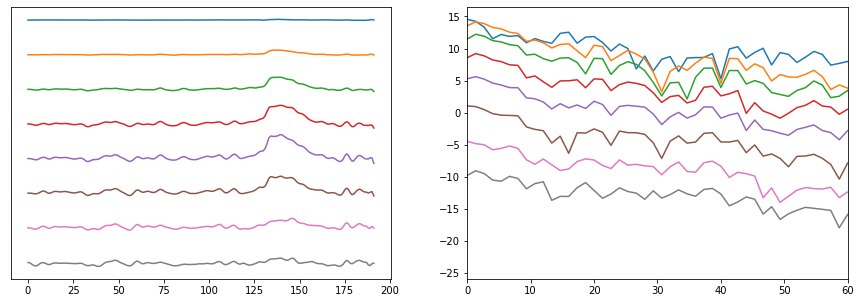

In [55]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
plt.plot(ff1[0].T + 0.5*np.arange(7,-1,-1));
plt.yticks([]);
plt.axis('tight');
plt.subplot(1,2,2)
plt.plot(freq, np.log(ff_fft[0].T) + 4*np.arange(7,-1,-1));
plt.xlim(0,60);

/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


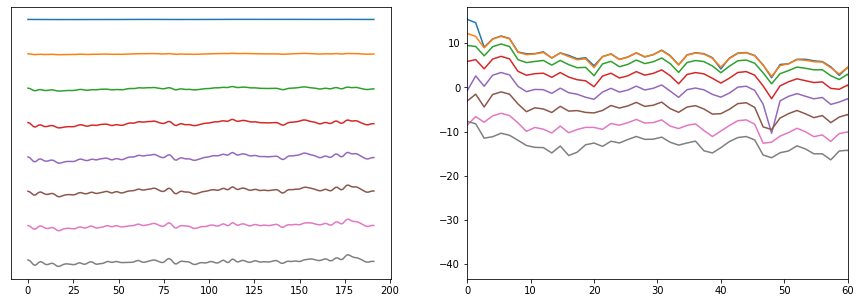

In [60]:
rr = np.swapaxes(train.squeeze(), 1,2)
freq, rr_fft = fft(rr)
rr_fft.shape

plt.figure(figsize=(15,5));
plt.subplot(1,2,1)
plt.plot(rr[0].T + 0.5*np.arange(7,-1,-1));
plt.yticks([]);
plt.axis('tight');
plt.subplot(1,2,2)
plt.plot(freq, np.log(rr_fft[0].T) + 4*np.arange(7,-1,-1));
plt.xlim(0,60);

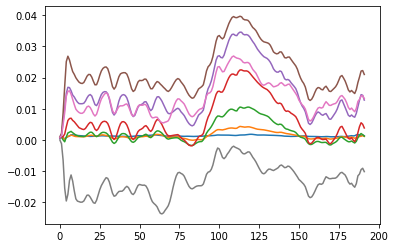

In [63]:
ffm = np.mean(ff1,axis=0)
plt.plot(ffm.T)
plt.show()

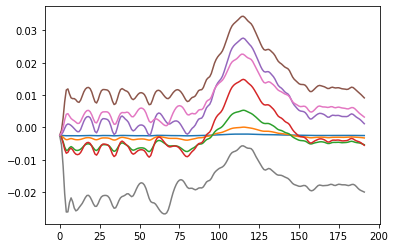

In [64]:
rrm = np.mean(rr,axis=0)
plt.plot(rrm.T)
plt.show()

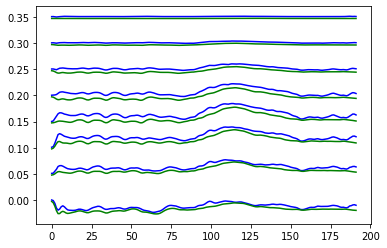

In [71]:
plt.plot(ffm.T+ 0.05*np.arange(7,-1,-1), 'b', label='mean fake');
plt.plot(rrm.T+ 0.05*np.arange(7,-1,-1), 'g', label='mean real');
#plt.legend();